In [2]:
import os
import numpy as np
import pandas as pd
import uproot as ur

from matplotlib import pyplot as plt
from IPython.display import Image
pd.set_option('display.max_columns', None) # to see all columns of df.head()
pd.set_option('display.max_rows', None)

# Lauren's colors
L_colors = ['red', 'darkorange', 'gold', 'limegreen', 'green', 'deepskyblue', 'blue', 'black']

In [21]:
# trk pt bins
trk_pt_lo = [1, 2, 3, 4, 6]
trk_pt_hi = [2, 3, 4, 6, 20]

def findbin(h_axis, value):
    edges = h_axis.edges()
    for i in range(len(edges)-1):
        if edges[i] <= value and value < edges[i+1]:
            return i
    return len(edges)-1

def yslice(th2d, bin_lo, bin_hi):
    h_slice = th2d.T[bin_lo:bin_hi]
    return np.sum(h_slice, axis=0)

def projectionXY(h):
    return np.sum(h, axis=2)

def xslice(th2d, bin_lo, bin_hi):
    h_slice = th2d[bin_lo:bin_hi]
    return np.sum(h_slice, axis=0)

def projectionX(h):
    if len(h.shape) == 3:
        return np.sum(projectionXY(h), axis=1)
    return np.sum(h, axis=1)

def projectionY(h):
    if len(h.shape) == 3:
        return np.sum(projectionXY(h), axis=0)
    return np.sum(h, axis=0)

def projectionZ(h):
    return np.sum(np.sum(h, axis=0), axis=0)


Njets : 1260188.0
4.704020352518829
2.2083816065539428
1.8266623710113092
0.6591825981520217
0.00864950309001514
0.0010887264439908965


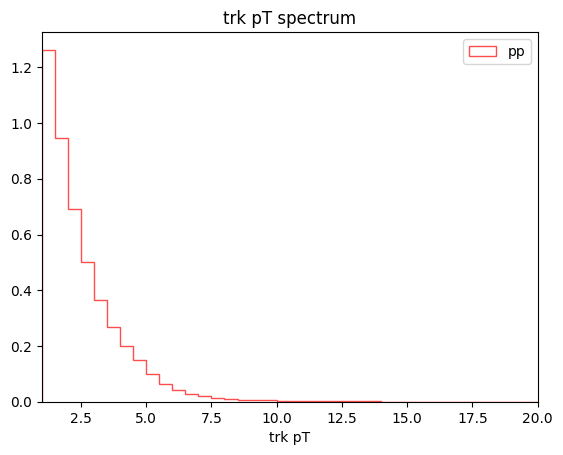

In [22]:
base_dir = "/global/cfs/cdirs/alice/kdevero/"
fs = [base_dir+"pp_jet-trk/19012324/merged.root"]#, "5020_PbPb_0-5/merged.root", "5020_PbPb_40-50/merged.root"]
f_names = ["pp", "Pb+Pb, 0-5%", "Pb+Pb, 40-50%"]

for fi in range(len(fs)):
    f = ur.open(fs[fi])
    
    h_jetpt = f["h_jet_pt_JetPt_R0.4_1.0"].to_numpy()[0]
    N_jets = np.sum(h_jetpt)
    print("Njets : " + str(N_jets))
    
    h = f["h_jet-trk_shape_JetPt_R0.4_1.0"]
    bin_edges = h.axis("y").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    h_numpy = h.to_numpy()[0]
    this_slice = projectionY(h_numpy)
    this_slice = this_slice / (bin_width * N_jets)
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[2*fi], label=f_names[fi])
    
    print(np.sum(this_slice))
    
    slices = [(0, 4), (4, 8), (8, 24), (24, 40), (40, 80)]
    for slici in slices:
        print(np.sum(this_slice[slici[0] : slici[1]]))
    
    """
    h = f["h_trkpt"]
    this_slice = np.sum(h.values().reshape(-1,2), axis=1)[:80]
    print(len(this_slice))
    print(len(bin_edges))
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[0])
    
    print(np.sum(this_slice))
    
    slices = [(0, 4), (4, 8), (8, 24), (24, 40), (40, 80)]
    for slici in slices:
        print(np.sum(this_slice[slici[0] : slici[1]]))
    """

plt.legend()
plt.title("trk pT spectrum") 
plt.xlabel('trk pT')
plt.xlim(1, 20)
#plt.xscale('log')
#plt.yscale('log')
plt.show()


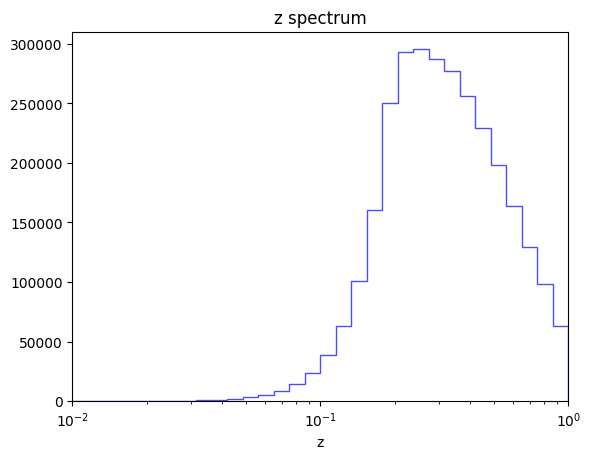

In [23]:
for fi in range(len(fs)):
    f = ur.open(fs[fi])
    
    h = f["h_jet-trk_shape_JetPt_R0.4_1.0"]
    bin_edges = h.axis("z").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    h_numpy = h.to_numpy()[0]
    this_slice = projectionZ(h_numpy)
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color="blue")
    
    plt.title("z spectrum") 
    plt.xlabel('z')
    plt.xlim(1e-2, 1)
    plt.xscale('log')
    #plt.yscale('log')
    plt.show()
    

Njets : 1260188.0
(2, 4)
1391488.0
(4, 6)
751098.0
(6, 8)
399871.0
(8, 12)
322798.0
(12, 40)
97999.0


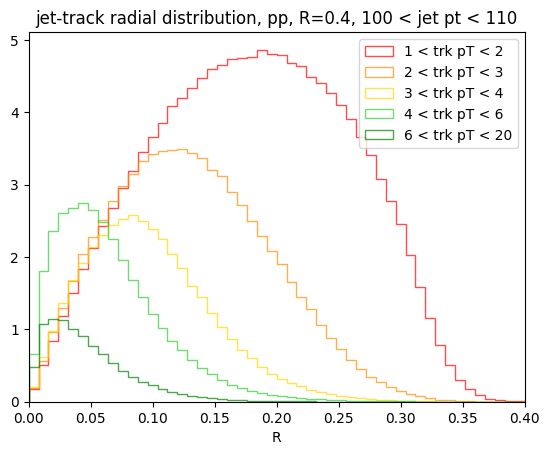

In [24]:
hs = []

for fi in range(len(fs)):
    f = ur.open(fs[fi])
    h = f["h_jet-trk_shape_JetPt_R0.4_1.0"]
    bin_edges = h.axis("x").edges()
    bin_width = bin_edges[1] - bin_edges[0]
    
    h_jetpt = f["h_jet_pt_JetPt_R0.4_1.0"].to_numpy()[0]
    N_jets = np.sum(h_jetpt)
    print("Njets : " + str(N_jets))
    
    h_numpy = h.to_numpy()[0]
    h_numpy = projectionXY(h_numpy)
    integrals = []
    h_trk = []
    for i in range(len(trk_pt_lo)):
        trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[i]), findbin(h.axis("y"), trk_pt_hi[i]))
        print(trk_pt_range)

        this_slice = yslice(h_numpy, trk_pt_range[0], trk_pt_range[1])
        print(np.sum(this_slice))
        this_slice = this_slice / (N_jets * bin_width)

        plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(trk_pt_lo[i], trk_pt_hi[i]))
        h_trk.append(this_slice)
    hs.append(h_trk)

    plt.legend(loc='upper right')
    plt.title("jet-track radial distribution, " + f_names[fi] + ", R=0.4, 100 < jet pt < 110") 
    plt.xlabel('R')
    plt.xlim(0, 0.4)
    #plt.ylim(0, 0.5)
    plt.show()


In [13]:
h = f["h_jet-trk_shape_JetPt_R0.4_1.0"]
bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

for fi in range(1,len(fs)):
    for j in range(len(trk_pt_lo)):
        
        h_to_graph = hs[fi][j] - hs[0][j]

        plt.hist(bin_edges[:-1], bin_edges, weights=h_to_graph, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[j], label='{} < trk pT < {}'.format(trk_pt_lo[j], trk_pt_hi[j]))
    
    plt.axhline(0, linestyle='--', color='gray')
    plt.legend(loc='lower right')
    plt.title("radial distribution, " + f_names[fi] + " - pp, R=0.4, 100 < jet pt < 110") 
    plt.xlabel('R')
    plt.xlim(0, 0.4)
    plt.ylim(-20, 20)
    plt.show()

[      0.   17232.   63537.  127070.  203699.  289887.  385064.  485458.
  590312.  698004.  807454.  917679. 1028521. 1138586. 1247078. 1353777.
 1458258. 1559418. 1658513. 1753889. 1846116. 1934430. 2019086. 2100083.]


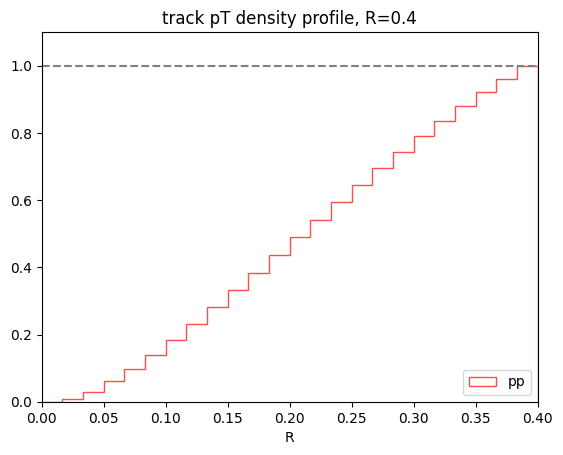

No artists with labels found to put in legend.  Note that artists whose label start with an underscore are ignored when legend() is called with no argument.


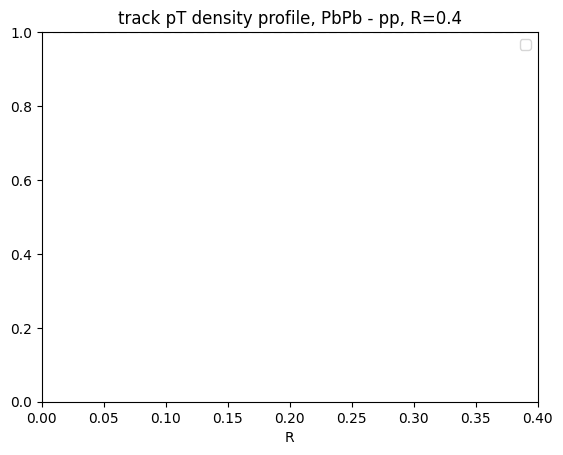

[]


In [14]:
hs = []
for i in range(len(fs)):
    f = ur.open(fs[i])
    h = f["h_jet-trk_shape_JetPt_R0.4_1.0"].to_numpy()[0]

    n_r_bins = 25
    bin_edges = np.linspace(0, 0.4, 25)
    bin_widths = 0.4 / n_r_bins

    integrals = []
    
    h_to_graph = np.array([np.sum(xslice(projectionX(h), 0, i)) for i in range(n_r_bins-1)])
    print(h_to_graph)
    
    # normalization by inclusive RL selection
    h_to_graph = h_to_graph / h_to_graph[len(h_to_graph)-1]
    hs.append(h_to_graph)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=h_to_graph, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[3*i], label=f_names[i])
    
plt.axhline(1, linestyle='--', color='gray')
plt.legend(loc='lower right')
plt.title("track pT density profile, R=0.4") 
plt.xlabel('R')
plt.xlim(0, 0.4)
plt.ylim(0, 1.1)
plt.show()



for i in range(1,len(fs)):
    h_to_graph = np.where(hs[0] != 0, np.divide(hs[i], hs[0]), 0)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=h_to_graph, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[3*i], label=f_names[i] + " - pp")
    
plt.axhline(1, linestyle='--', color='gray')
plt.legend(loc='upper right')
plt.title("track pT density profile, PbPb - pp, R=0.4") 
plt.xlabel('R')
plt.xlim(0, 0.4)
plt.show()
print(integrals)

(2, 4)
(4, 6)
(6, 8)
(8, 12)
(12, 40)


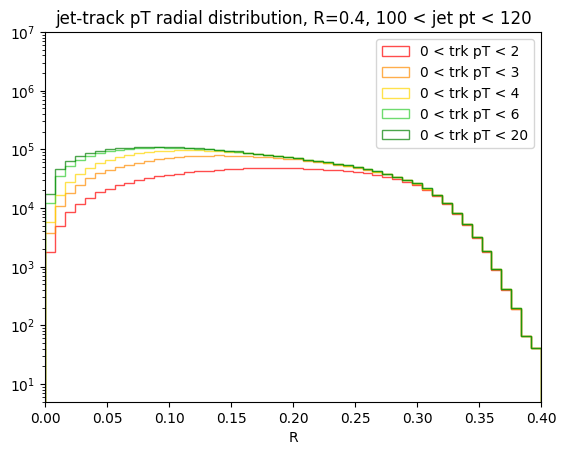

[1391488.0, 2142586.0, 2542457.0, 2865255.0, 2963254.0]


In [25]:
f = ur.open(fs[0])
h = f["h_jet-trk_shape_JetPt_R0.4_1.0"]
h_numpy = h.to_numpy()[0]
h_numpy = projectionXY(h_numpy)

bin_edges = h.axis("x").edges()
bin_width = bin_edges[1] - bin_edges[0]

integrals = []
for i in range(len(trk_pt_lo)):
    trk_pt_range = (findbin(h.axis("y"), trk_pt_lo[i]), findbin(h.axis("y"), trk_pt_hi[i]))
    print(trk_pt_range)
    
    this_slice = yslice(h_numpy, 0, trk_pt_range[1])
    integrals.append(np.sum(this_slice))
    #this_slice = this_slice / np.sum(this_slice)
    
    plt.hist(bin_edges[:-1], bin_edges, weights=this_slice, lw=1, histtype = 'step', alpha=0.7, fill=False, color=L_colors[i], label='{} < trk pT < {}'.format(0, trk_pt_hi[i]))
    
plt.legend(loc='upper right')
plt.title("jet-track pT radial distribution, R=0.4, 100 < jet pt < 120") 
plt.xlabel('R')
plt.yscale("log")
plt.xlim(0, 0.4)
plt.ylim(5e0, 1e7)
plt.show()
print(integrals)